In [1]:
from fastai.vision.all import *

# Imagenette

Small subset of imagenet, containing 10 'very different' categories'.

In [2]:
path = untar_data(URLs.IMAGENETTE)

In [10]:
files = list(get_image_files(path))

In [15]:
file = files[0]
file.parent.name

'n03028079'

In [21]:
df = pd.DataFrame(files, columns=['filename'])
df['target'] = df['filename'].apply(lambda p: p.parent.name)
df['is_valid'] = df['filename'].apply(lambda p: 'val' in str(p.parent))
df.head()

,filename,target,is_valid
0,/storage/data/imagenette2/val/n03028079/ILSVRC2012_val_00034021.JPEG,n03028079,True
1,/storage/data/imagenette2/val/n03028079/n03028079_31602.JPEG,n03028079,True
2,/storage/data/imagenette2/val/n03028079/n03028079_2782.JPEG,n03028079,True
3,/storage/data/imagenette2/val/n03028079/n03028079_50060.JPEG,n03028079,True
4,/storage/data/imagenette2/val/n03028079/n03028079_13981.JPEG,n03028079,True


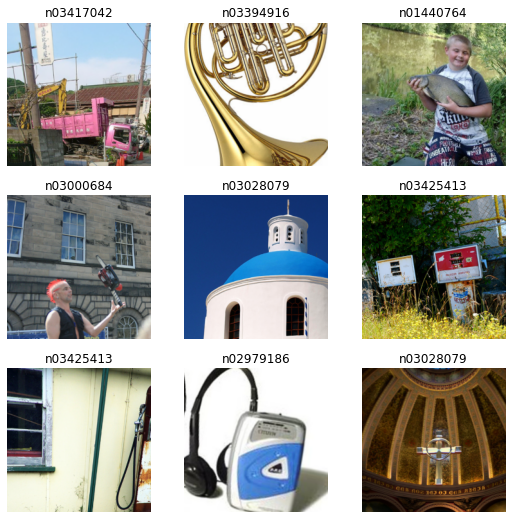

In [25]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   splitter=ColSplitter(),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75),
                  )
dls = dblock.dataloaders(df.sample(len(df)//4), bs=32)
dls.show_batch()

In [27]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.567573,7.412076,0.114314,00:31
1,1.920750,1.991285,0.416501,00:28
2,1.649812,2.059447,0.363817,00:28
3,1.358585,1.357774,0.575547,00:28
4,1.145984,1.131791,0.661034,00:28


# Normalization